# 1. Data Collection

#### 따로 추가할 데이터가 있으면 여기서 wget 하거나 jupyter 자체에서 파일 upload 가능

In [1]:
!ls

0.data	       4.Picard    8.RAxML	     nohup.out	     temp.txt
1.Fastq_dump   5.GATK	   datatemp	     rule.png	     Untitled.ipynb
2.Trimmomatic  6.VCF	   examples.desktop  Snakefile	     VCF_test
3.Bowtie2      7.FastTree  FastTreeMP	     standard-RAxML  VCFtoFASTA.py


In [4]:
!cat 0.data/SampleList.sh

wget ftp://ftp-trace.ncbi.nih.gov/sra/sra-instant/reads/ByRun/sra/SRR/SRR766/SRR766010/SRR766010.sra
wget ftp://ftp-trace.ncbi.nih.gov/sra/sra-instant/reads/ByRun/sra/SRR/SRR766/SRR766059/SRR766059.sra
wget ftp://ftp-trace.ncbi.nih.gov/sra/sra-instant/reads/ByRun/sra/SRR/SRR764/SRR764718/SRR764718.sra
wget ftp://ftp-trace.ncbi.nih.gov/sra/sra-instant/reads/ByRun/sra/SRR/SRR764/SRR764691/SRR764691.sra
wget ftp://ftp-trace.ncbi.nih.gov/sra/sra-instant/reads/ByRun/sra/SRR/SRR716/SRR716646/SRR716646.sra
wget ftp://ftp-trace.ncbi.nih.gov/sra/sra-instant/reads/ByRun/sra/SRR/SRR715/SRR715903/SRR715903.sra
wget ftp://ftp-trace.ncbi.nih.gov/sra/sra-instant/reads/ByRun/sra/SRR/SRR718/SRR718069/SRR718069.sra
wget ftp://ftp-trace.ncbi.nih.gov/sra/sra-instant/reads/ByRun/sra/SRR/SRR715/SRR715903/SRR715903.sra
wget ftp://ftp-trace.ncbi.nih.gov/sra/sra-instant/reads/ByRun/sra/SRR/SRR701/SRR701476/SRR701476.sra
wget ftp://ftp-trace.ncbi.nih.gov/sra/sra-instant/reads/ByRun/sra/SRR/SRR715/SRR715904/SRR7

In [2]:
!ls 0.data/

dbSNP150	      SRR716428.sra	       SRR766010.sra
download.sh	      SRR716646_1.fastq.gz     SRR766013_1.fastq.gz
nohup.out	      SRR716646_2.fastq.gz     SRR766013_2.fastq.gz
Reference	      SRR716646.sra	       SRR766013.sra
SampleList.sh	      SRR718069_1.fastq.gz     SRR766029_1.fastq.gz
SRR701476_1.fastq.gz  SRR718069_2.fastq.gz     SRR766029_2.fastq.gz
SRR701476_2.fastq.gz  SRR718069.sra	       SRR766029.sra
SRR701476.sra	      SRR764691_1.fastq.gz     SRR766031_1.fastq.gz
SRR707197_1.fastq.gz  SRR764691_2.fastq.gz     SRR766031_2.fastq.gz
SRR707197_2.fastq.gz  SRR764691.sra	       SRR766031.sra
SRR707197.sra	      SRR764718_1_fastqc.html  SRR766059_1.fastq.gz
SRR715903_1.fastq.gz  SRR764718_1_fastqc.zip   SRR766059_2.fastq.gz
SRR715903_2.fastq.gz  SRR764718_1.fastq.gz     SRR766059.sra
SRR715903.sra	      SRR764718_2_fastqc.html  SRR768534_1.fastq.gz
SRR715904_1.fastq.gz  SRR764718_2_fastqc.zip   SRR768534_2.fastq.gz
SRR715904_2.fastq.gz  SRR764718_2.fastq.gz     SRR768534.sra
S

In [4]:
!ls 1.Fastq_dump/

SRR701476_1.fastq.gz  SRR716646_1.fastq.gz  SRR766013_1.fastq.gz
SRR701476_2.fastq.gz  SRR716646_2.fastq.gz  SRR766013_2.fastq.gz
SRR707197_1.fastq.gz  SRR718069_1.fastq.gz  SRR766029_1.fastq.gz
SRR707197_2.fastq.gz  SRR718069_2.fastq.gz  SRR766029_2.fastq.gz
SRR715903_1.fastq.gz  SRR764691_1.fastq.gz  SRR766031_1.fastq.gz
SRR715903_2.fastq.gz  SRR764691_2.fastq.gz  SRR766031_2.fastq.gz
SRR715904_1.fastq.gz  SRR764718_1.fastq.gz  SRR766059_1.fastq.gz
SRR715904_2.fastq.gz  SRR764718_2.fastq.gz  SRR766059_2.fastq.gz
SRR716428_1.fastq.gz  SRR766010_1.fastq.gz  SRR768534_1.fastq.gz
SRR716428_2.fastq.gz  SRR766010_2.fastq.gz  SRR768534_2.fastq.gz


# 2. Run the Pipeline

### 다음과 같은 과정으로 진행되는 Snakemake pipeline 작성

#### 1. Trimmomatic으로 Read Quality Control 및 Adapter 제거
#### 2. Bowtie2로 Reference Mapping
#### 3. Picard tool로 BAM 파일 processing (PCR duplicate 제거, Paired end read 보정)
#### 4. GATK pipeline으로 Variant Calling (InDel local realign, base quality recalibration, haplotypecaller)
#### 5. GATK pipeline으로 SNP 추출 및 Quality Filtering (QUAL, QD, MQ, FS 필터링)
#### 6. VCFtools로 최종적인 SNP filtering (Missing Genotype, MAF, Read depth)

In [6]:
!cat Snakefile

import glob, os

### ENV
OrgName = "1000Genome"
suffix = ".fastq.gz"
prefix = "1.Fastq_dump/"
refSuffix = ".fa"

### FILES
RefFile = "0.data/Reference/hg38"+refSuffix


### VAR
SampleList = glob.glob(prefix+"*_1*"+suffix)
SampleList = [a_sample[len(prefix):-len(suffix)-2] for a_sample in SampleList]


### MAKE DIR
os.system("mkdir 2.Trimmomatic")
os.system("mkdir 3.Bowtie2")
os.system("mkdir 4.Picard")
os.system("mkdir 4.Picard/RG_bam")
os.system("mkdir 4.Picard/RG_DU_bam")
os.system("mkdir 4.Picard/RG_DU_FIX_bam")
os.system("mkdir 5.GATK")
os.system("mkdir 5.GATK/HaplotypeCaller")
os.system("mkdir 5.GATK/RG_REaln_bam")
os.system("mkdir 5.GATK/RG_REaln_REcal_bam")
os.system("mkdir 5.GATK/SelectVariants")
os.system("mkdir 6.VCF")

### ANNOUNCE
print("Start run. Samples:")
print(SampleList)

### RUN
rule all:
#	input: "5.GATK/VariantFiltration/{}.snp.vcf".format(OrgName), "5.GATK/VariantFiltration/{}.indel.vcf".format(OrgName)
	input: "6.VCF/final.vcf"

rule trimmomatic:
    input: prefi

In [8]:
!snakemake --allowed-rules renameFinalVCF

mkdir: cannot create directory ‘2.Trimmomatic’: File exists
mkdir: cannot create directory ‘3.Bowtie2’: File exists
mkdir: cannot create directory ‘4.Picard’: File exists
mkdir: cannot create directory ‘4.Picard/RG_bam’: File exists
mkdir: cannot create directory ‘4.Picard/RG_DU_bam’: File exists
mkdir: cannot create directory ‘4.Picard/RG_DU_FIX_bam’: File exists
mkdir: cannot create directory ‘5.GATK’: File exists
mkdir: cannot create directory ‘5.GATK/HaplotypeCaller’: File exists
mkdir: cannot create directory ‘5.GATK/RG_REaln_bam’: File exists
mkdir: cannot create directory ‘5.GATK/RG_REaln_REcal_bam’: File exists
mkdir: cannot create directory ‘5.GATK/SelectVariants’: File exists
mkdir: cannot create directory ‘6.VCF’: File exists
Start run. Samples:
['SRR715904', 'SRR701476', 'SRR768534', 'SRR707197', 'SRR766010', 'SRR716428', 'SRR716646', 'SRR766013', 'SRR718069', 'SRR766031', 'SRR764718', 'SRR764691', 'SRR766059', 'SRR766029', 'SRR715903']
Building DAG of jobs...
Provided core

In [13]:
!snakemake --rulegraph > rule.txt
!dot -Tpng rule.txt > rule.png

Building DAG of jobs...


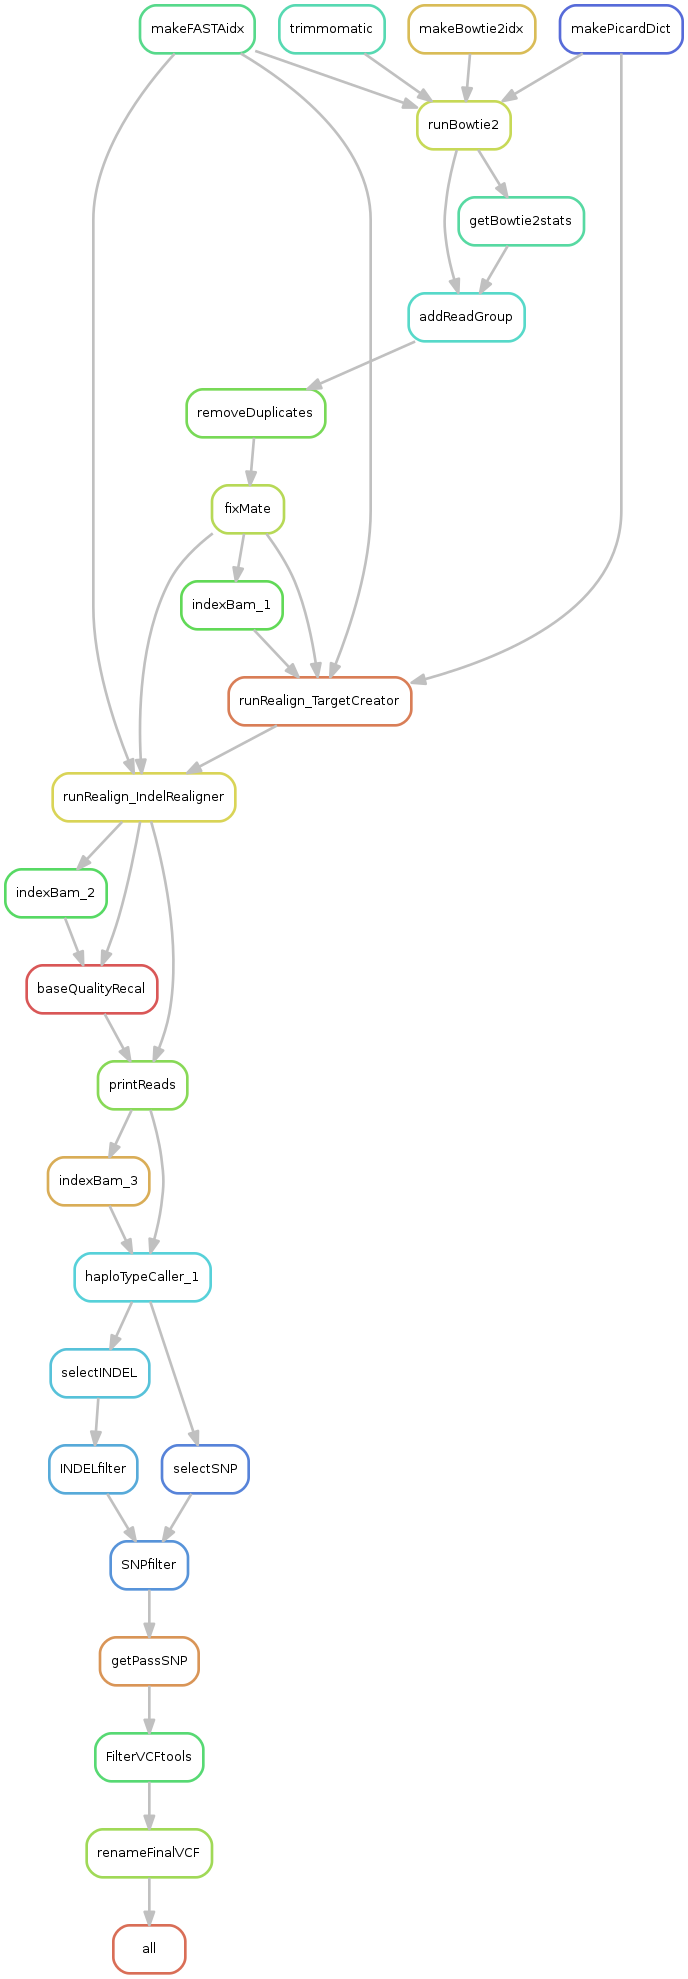

In [14]:
from IPython.display import Image
Image("rule.png")

# 3. VCF에서 MySQL DB 연동

#### 각 loci의 위치 정보 및 alternative allele의 수와 같은 데이터를 그대로 보존하기 위하여 VCF에서 바로 MySQL DB로 변환

###  3.1. MySQL DB 연결

In [19]:
import pymysql

In [146]:
conn = pymysql.connect(host="localhost", user="hs0517", password="SNP", db="2018_BI3_hs0517", charset="utf8")

In [147]:
curs = conn.cursor()

In [114]:
curs.execute("SHOW DATABASES;")
print("Current DB :", curs.fetchall())
curs.execute("SHOW TABLES;")
print("Tables on DB :", curs.fetchall())

Current DB : (('information_schema',), ('2018_BI3_hs0517',))
Tables on DB : (('metadata',),)


### 3.2. SNP table 생성

#### DB 내 table은 다음과 같은 schema로 구성됨

#### 1. metadata : SRA entry, Sample name, sex, population으로 구성
#### 2. genotype : SRA entry, chromosome, position, number of alternative alleles(AAcount)로 구성

In [115]:
sql = """
CREATE TABLE IF NOT EXISTS metadata
(
    SRA_entry VARCHAR(40) NOT NULL,
    Sample_name VARCHAR(40) NOT NULL,
    Sex VARCHAR(10),
    Population VARCHAR(10) NOT NULL,
    PRIMARY KEY(SRA_entry)
);
"""
curs.execute(sql)
conn.commit()

/home/hs0517/.pyenv/versions/py36/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1050, "Table 'metadata' already exists")
  result = self._query(query)


In [120]:
sql = """
CREATE TABLE IF NOT EXISTS genotype
(
    Chrom INT UNSIGNED,
    POS INT UNSIGNED,
    Ref CHAR(1),
    Alt CHAR(1)
);
"""
curs.execute(sql)
conn.commit()

### 3.3. DB 내용 채우기

#### metadata 채우기

In [93]:
import pandas as pd
#Sample Metadata
df = pd.DataFrame({"name":["NA11995", "NA12004", "NA07056", "NA12156", "NA12815", "NA18531", "NA18527", "NA18618", "NA18640", "NA18525", "NA18939", "NA18957", "NA18992", "NA18941", "NA18998"],
                  "sex":["Female", "Female", "Female", "Female", "Female", "Female", "Female", "Female", "Female", "Female", "Female", "Female", "Female", "Female", "Female"],
                  "population":["CEU", "CEU", "CEU", "CEU", "CEU", "CHB", "CHB", "CHB", "CHB", "CHB", "JPT", "JPT", "JPT", "JPT", "JPT"],
                  "sra":["SRR766010", "SRR766059", "SRR764718", "SRR764691", "SRR716646", "SRR715903", "SRR718069", "SRR707197", "SRR701476", "SRR715904", "SRR766031", "SRR768534", "SRR716428", "SRR766029", "SRR766013"]})

In [94]:
for idx, row in df.iterrows():
    # sra, name, sex, population
    sql = "INSERT IGNORE INTO metadata VALUES(\"{}\",\"{}\",\"{}\",\"{}\");".format(row[3], row[0], row[1], row[2])
    curs.execute(sql)
conn.commit()

#### VCF 파싱해서 genotype table 채우기

In [95]:
from pysam import VariantFile

In [117]:
VCFfile = VariantFile("6.VCF/final.vcf")

#### Sample에 대한 column 만들어주기

In [121]:
for sample in VCFfile.header.samples:
    sql = "ALTER TABLE genotype ADD COLUMN {} INT;".format(sample)
    curs.execute(sql)
    conn.commit()

In [148]:
curs.execute("DESCRIBE genotype;")
print(curs.fetchall())

(('Chrom', 'int(10) unsigned', 'YES', '', None, ''), ('POS', 'int(10) unsigned', 'YES', '', None, ''), ('Ref', 'char(1)', 'YES', '', None, ''), ('Alt', 'char(1)', 'YES', '', None, ''), ('SRR701476', 'int(11)', 'YES', '', None, ''), ('SRR707197', 'int(11)', 'YES', '', None, ''), ('SRR715903', 'int(11)', 'YES', '', None, ''), ('SRR715904', 'int(11)', 'YES', '', None, ''), ('SRR716428', 'int(11)', 'YES', '', None, ''), ('SRR716646', 'int(11)', 'YES', '', None, ''), ('SRR718069', 'int(11)', 'YES', '', None, ''), ('SRR764691', 'int(11)', 'YES', '', None, ''), ('SRR764718', 'int(11)', 'YES', '', None, ''), ('SRR766010', 'int(11)', 'YES', '', None, ''), ('SRR766013', 'int(11)', 'YES', '', None, ''), ('SRR766029', 'int(11)', 'YES', '', None, ''), ('SRR766031', 'int(11)', 'YES', '', None, ''), ('SRR766059', 'int(11)', 'YES', '', None, ''), ('SRR768534', 'int(11)', 'YES', '', None, ''))


In [126]:
for row in VCFfile.fetch():
    sex_chrom = {"X":23, "Y":24}
    if (row.chrom not in [str(i) for i in range(1, 23)]) and (row.chrom not in sex_chrom): continue

    chrom = sex_chrom[row.chrom] if row.chrom in sex_chrom else row.chrom
    pos = row.pos
    
    AAcount = {}
    for sample in VCFfile.header.samples:
        AAcount[sample] = row.samples[sample]["GT"].count(1)
        
    # Chrom, Pos, Ref, Alt, Sample1, Sample2, ...
        
    sql = "INSERT IGNORE INTO genotype (Chrom, POS, Ref, Alt, " + ",".join([sample for sample in VCFfile.header.samples]) + ")" + \
    " VALUES({},{},\"{}\",\"{}\",".format(chrom, pos, row.ref, row.alts[0]) + \
    ",".join([str(AAcount[sample]) for sample in VCFfile.header.samples]) + ");"
        
    curs.execute(sql)
    conn.commit()

In [128]:
curs.execute("select distinct Chrom from genotype;")
print(curs.fetchall())

((24,), (5,), (9,), (3,), (18,), (17,), (10,), (23,), (2,), (19,), (22,), (20,), (21,), (16,), (7,), (8,), (1,), (11,), (4,), (14,), (6,), (12,), (13,), (15,))


### 3.4. schema visualize 하여 확인

In [122]:
!java -jar schemaSpy_5.0.0.jar -t mysql -u hs0517 -p SNP -host localhost -db 2018_BI3_hs0517 -o ./7.DBschema -dp /usr/share/java/mysql-connector-java.jar

Using database properties:
  [schemaSpy_5.0.0.jar]/net/sourceforge/schemaspy/dbTypes/mysql.properties
Mon May 28 20:42:22 KST 2018 WARN: Establishing SSL connection without server's identity verification is not recommended. According to MySQL 5.5.45+, 5.6.26+ and 5.7.6+ requirements SSL connection must be established by default if explicit option isn't set. For compliance with existing applications not using SSL the verifyServerCertificate property is set to 'false'. You need either to explicitly disable SSL by setting useSSL=false, or set useSSL=true and provide truststore for server certificate verification.
Gathering schema details.....(0sec)
Writing/graphing summary.........(0sec)
Writing/diagramming details..(0sec)
Wrote relationship details of 2 tables/views to directory './7.DBschema' in 1 seconds.
View the results by opening ./7.DBschema/index.html


# 4. PCA

### 조건에 따라 다른 Fasta를 만들 수 있도록 Query (Chrom, Pos, Sample 등)

#### MySQL table에 Query를 보내 0, 1, 2 coding된 데이터를 얻어옴

In [155]:
TargetSRA = ['SRR701476', 'SRR707197', 'SRR715903', 'SRR715904', 'SRR716428', 'SRR716646', 'SRR718069', \
 'SRR764691', 'SRR764718', 'SRR766010', 'SRR766013', 'SRR766029', 'SRR766031', 'SRR766059', 'SRR768534']
TargetChrom = [1, 2]
TargetPos = [(1, 100000000), (5000000, 20000000)]

In [159]:
GenoMatrix = pd.DataFrame(columns=TargetSRA)

for Chrom in TargetChrom:
    for Pos in TargetPos:
        # By ascending order of POS
        curs.execute("select {} from genotype where Chrom={} AND POS>{} AND POS<{} ORDER BY POS;".format(",".join(TargetSRA), Chrom, Pos[0], Pos[1]))
        sample_genotype = curs.fetchall()

        for i in range(len(GenoMatrix.index), len(sample_genotype)):
            GenoMatrix.loc[i] = list(sample_genotype[i])            

In [161]:
GenoMatrix.head

<bound method NDFrame.head of       SRR701476 SRR707197 SRR715903 SRR715904 SRR716428 SRR716646 SRR718069  \
0             1         0         1         2         1         2         1   
1             1         0         1         2         1         2         1   
2             0         0         0         0         1         0         0   
3             0         0         0         0         1         0         0   
4             0         0         0         0         1         0         0   
5             0         0         0         0         1         0         0   
6             0         1         0         0         1         0         0   
7             0         1         0         0         1         0         0   
8             2         2         2         2         2         2         2   
9             2         2         2         2         2         2         2   
10            1         2         1         2         1         1         2   
11            1       

In [166]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [184]:
pca = PCA(n_components=5)
pca.fit(GenoMatrix)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [192]:
pca.components_

array([[ 0.26192522,  0.27551931,  0.27602794,  0.28723471,  0.28980899,
         0.22089867,  0.26830812,  0.21683772,  0.23049416,  0.21955474,
         0.26476786,  0.27524635,  0.2736932 ,  0.20714274,  0.28281667],
       [-0.11996693, -0.19179499, -0.12867241, -0.21087401, -0.21799036,
         0.40638183, -0.10321111,  0.44073377,  0.34942004,  0.38032054,
        -0.16513939, -0.12924714, -0.17513125,  0.3493756 , -0.08237244],
       [-0.26124047, -0.10143743, -0.26019437,  0.28497496,  0.17794869,
         0.10600841, -0.23808758, -0.31145115, -0.06866655, -0.21356188,
        -0.05773385,  0.17266913,  0.20911621,  0.66543299, -0.07719285],
       [-0.29175225,  0.14891311,  0.1082021 , -0.06852659,  0.39747126,
        -0.11476757, -0.05043582, -0.03991305, -0.19930642,  0.56000109,
         0.03269978,  0.21553973, -0.06913542, -0.07949308, -0.5376433 ],
       [ 0.19806917,  0.63145982, -0.12282326, -0.10123468, -0.04706227,
         0.00864653,  0.26120191, -0.19655022, 

### PVE (Percentage of Variance Explained)

In [185]:
print('explained variance ratio (first five components): %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio (first five components): [0.45297319 0.09831702 0.04428617 0.04039205 0.03950517]


### Figure

In [175]:
import seaborn as sns

In [194]:
pc_df = pd.DataFrame(pca.components_.transpose(), 
        columns = ['PC1', 'PC2','PC3','PC4', 'PC5'])

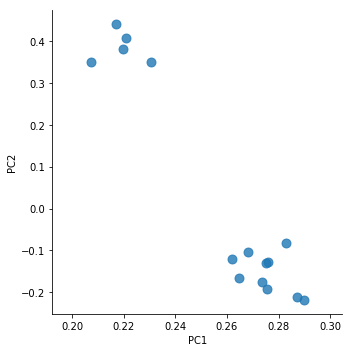

In [195]:
sns.lmplot( x="PC1", y="PC2",
  data=pc_df, 
  fit_reg=False,
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

# 5. MySQL에서 Fasta 포맷으로 추출

#### Fasta 작성 시 몇가지 정보 손실이 불가피
#### 대표적으로 Chromosome, Position 등의 정보가 손실됨

In [131]:
curs.execute("select sra_entry from metadata;")
SRA_entry = [SRA_name[0] for SRA_name in curs.fetchall()]
SRA_entry

['SRR701476',
 'SRR707197',
 'SRR715903',
 'SRR715904',
 'SRR716428',
 'SRR716646',
 'SRR718069',
 'SRR764691',
 'SRR764718',
 'SRR766010',
 'SRR766013',
 'SRR766029',
 'SRR766031',
 'SRR766059',
 'SRR768534']

### 조건에 따라 다른 Fasta를 만들 수 있도록 Query (Chrom, Pos, Sample 등)

In [133]:
TargetSRA = ['SRR701476', 'SRR707197', 'SRR715903', 'SRR715904', 'SRR716428', 'SRR716646', 'SRR718069', \
 'SRR764691', 'SRR764718', 'SRR766010', 'SRR766013', 'SRR766029', 'SRR766031', 'SRR766059', 'SRR768534']
TargetChrom = [1]
TargetPos = [(1, 100000000)]

In [150]:
SRASequence = {}

for Chrom in TargetChrom:
    for Pos in TargetPos:
        for SRA in TargetSRA:
            # By ascending order of POS
            curs.execute("select Ref, Alt, {} from genotype where Chrom={} AND POS>{} AND POS<{} ORDER BY POS;".format(SRA, Chrom, Pos[0], Pos[1]))
            sample_genotype = curs.fetchall()
            
            SRASequence.setdefault(SRA, "")
            
            for locus in sample_genotype:
                SRASequence[SRA] += locus[0] if locus[2] == 0 else locus[1]

In [199]:
outFastaName = "8.Fasta/SNPseq.fa"

with open(outFastaName, "w") as outfile:
    for SRA in SRASequence:
        print(">", SRA, sep="", file=outfile)
        print(SRASequence[SRA], file=outfile)

# 6. Phylogenetic 분석

### 6.1. FastTree ML tree with bootstrap value

#### 6.1.1. Fasta 포맷에서 Phylip 및 nexus 포맷으로 변경 (bootstrap하기 위해)

In [200]:
import sys, os, glob

def Read_fasta_sequence(sFname):
    Infile = open(sFname, "r")
    Out_dic = {}

    for sLine in Infile:
        if sLine.startswith(">"):
            sSample = sLine.strip()[1:]
            Out_dic.setdefault(sSample, "")
        else:
            Out_dic[sSample] += sLine.strip()

    Infile.close()
    return Out_dic

def Fasta_to_phylip(sFname, Seq_dic):
    Sample_list = sorted(Seq_dic.keys())
    nSeq_length = len(Seq_dic[Sample_list[0]])
    Outfile = open(sFname.replace(".fa",".phylip"), "w")
    Outfile.write(str(len(Sample_list))+" "+str(nSeq_length)+"\n")
    for i in range(0, nSeq_length, 100):
        for sSample in Sample_list:
            sTemp_seq = Seq_dic[sSample][i:i+100]
            sTemp_list = [sTemp_seq[j:j+20] for j in range(0, len(sTemp_seq), 20)]
            if i==0:
                Outfile.write(sSample.ljust(15, " ")+" ".join(sTemp_list)+"\n")
            else:
                Outfile.write(" "*15+" ".join(sTemp_list)+"\n")
        Outfile.write("\n")
    Outfile.close()

def Fasta_to_nexus(sFname, Seq_dic):
    Sample_list = sorted(Seq_dic.keys())
    nSeq_length = len(Seq_dic[Sample_list[0]])
    Outfile = open(sFname.replace(".fa",".nexus"), "w")
    Outfile.write("#NEXUS"+"\n"\
            "BEGIN DATA;"+"\n"\
            "dimensions ntax="+str(len(Sample_list))+" nchar="+str(nSeq_length)+";"+"\n"\
            "format missing=?"+"\n"\
            "symbols=\"ABCDEFGHIKLMNPQRSTUVWXYZ\""+"\n"\
            "interleave datatype=DNA gap= -;"+"\n"+"\n"\
            "matrix"+"\n")

    for i in range(0, nSeq_length, 100):
        for sSample in Sample_list:
            sTemp_seq = Seq_dic[sSample][i:i+100]
            sTemp_list = [sTemp_seq[j:j+20] for j in range(0, len(sTemp_seq), 20)]
            Outfile.write(sSample.ljust(15, " ")+" ".join(sTemp_list)+"\n")
            Outfile.write("\n")

    Outfile.write(";"+"\n")
    Outfile.write("END;"+"\n")

sFlist = ["8.Fasta/SNPseq.fa"]
#print sFlist

for i in sFlist:
    #print i
    Seq_dic = Read_fasta_sequence(i)
    Fasta_to_phylip(i, Seq_dic)
    Fasta_to_nexus(i, Seq_dic)

#### 6.1.2. FastTree 실행 (bootstrap 100)

In [202]:
!./FastTreeMP -n 100 < 8.Fasta/SNPseq.phylip > 9.FastTree/TreeOut

FastTree Version 2.1.10 SSE3, OpenMP (24 threads)
Alignment: standard input (100 alignments)
Amino acid distances: BLOSUM45 Joins: balanced Support: SH-like 1000
Search: Normal +NNI +SPR (2 rounds range 10) +ML-NNI opt-each=1
TopHits: 1.00*sqrtN close=default refresh=0.80
ML Model: Jones-Taylor-Thorton, CAT approximation with 20 rate categories
WARNING! 100.0% NUCLEOTIDE CHARACTERS -- IS THIS REALLY A PROTEIN ALIGNMENT?
Initial topology in 0.21 seconds
Refining topology: 16 rounds ME-NNIs, 2 rounds ME-SPRs, 8 rounds ML-NNIs
Total branch-length 3.343 after 1.31 sec6, 1 of 13 splits   
ML-NNI round 1: LogLk = -218638.536 NNIs 3 max delta 226.31 Time 2.81
Switched to using 20 rate categories (CAT approximation)20 of 20   
Rate categories were divided by 0.871 so that average rate = 1.0
CAT-based log-likelihoods may not be comparable across runs
Use -gamma for approximate but comparable Gamma(20) log-likelihoods
ML-NNI round 2: LogLk = -212222.753 NNIs 0 max delta 0.00 Time 4.89
Turning of

#### 6.1.3. FigTree로 Visualization

In [206]:
!java -jar FigTree_v1.4.3/lib/figtree.jar -graphic PNG -width 320 -height 320 9.FastTree/TreeOut 9.FastTree/TreeOut.png


                 FigTree v1.4.3, 2006-2016
                  Tree Figure Drawing Tool
                       Andrew Rambaut

             Institute of Evolutionary Biology
                  University of Edinburgh
                     a.rambaut@ed.ac.uk

                 http://tree.bio.ed.ac.uk/
    Uses the Java Evolutionary Biology 2 Library (JEBL2)
                http://jebl2.googlecode.com/
 Thanks to Alexei Drummond, Joseph Heled, Philippe Lemey, 
Tulio de Oliveira, Oliver Pybus, Beth Shapiro & Marc Suchard

Creating PNG graphic: 9.FastTree/TreeOut.png


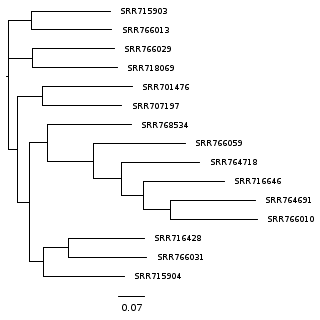

In [207]:
Image("9.FastTree/TreeOut.png")

### 6.2. RAxML ML tree with bootstrap value

#### 6.2.1. RAxML run

In [209]:
!standard-RAxML/raxmlHPC-PTHREADS-SSE3 -T 24 -m GTRCAT -s 8.Fasta/SNPseq.phylip -n TreeOut --bootstop-perms=100 -p 9



Using BFGS method to optimize GTR rate parameters, to disable this specify "--no-bfgs" 


This is the RAxML Master Pthread

This is RAxML Worker Pthread Number: 2

This is RAxML Worker Pthread Number: 1

This is RAxML Worker Pthread Number: 3

This is RAxML Worker Pthread Number: 4

This is RAxML Worker Pthread Number: 5

This is RAxML Worker Pthread Number: 6

This is RAxML Worker Pthread Number: 7

This is RAxML Worker Pthread Number: 8

This is RAxML Worker Pthread Number: 9

This is RAxML Worker Pthread Number: 10

This is RAxML Worker Pthread Number: 11

This is RAxML Worker Pthread Number: 14

This is RAxML Worker Pthread Number: 13

This is RAxML Worker Pthread Number: 16

This is RAxML Worker Pthread Number: 15

This is RAxML Worker Pthread Number: 17

This is RAxML Worker Pthread Number: 12

This is RAxML Worker Pthread Number: 19

This is RAxML Worker Pthread Number: 18

This is RAxML Worker Pthread Number: 22

This is RAxML Worker Pthread Number: 21

This is RAxML Worker P

In [210]:
!mv RAxML*TreeOut 10.RAxML

#### 6.2.2. FigTree로 Visualization

In [211]:
!java -jar FigTree_v1.4.3/lib/figtree.jar -graphic PNG -width 320 -height 320 10.RAxML/RAxML_result.TreeOut 10.RAxML/TreeOut.png


                 FigTree v1.4.3, 2006-2016
                  Tree Figure Drawing Tool
                       Andrew Rambaut

             Institute of Evolutionary Biology
                  University of Edinburgh
                     a.rambaut@ed.ac.uk

                 http://tree.bio.ed.ac.uk/
    Uses the Java Evolutionary Biology 2 Library (JEBL2)
                http://jebl2.googlecode.com/
 Thanks to Alexei Drummond, Joseph Heled, Philippe Lemey, 
Tulio de Oliveira, Oliver Pybus, Beth Shapiro & Marc Suchard

Creating PNG graphic: 10.RAxML/TreeOut.png


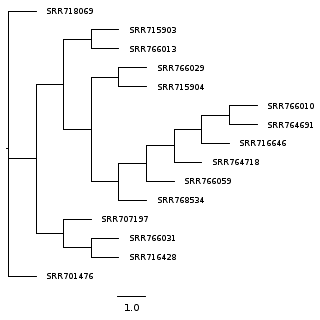

In [212]:
Image("10.RAxML/TreeOut.png")

### 6.3. Phylip NJ tree with bootstrap value

#### 6.3.1. Seqboot

In [214]:
!printf '8.Fasta/SNPseq.phylip\nY\n9\n' | phylip seqboot
!mv outfile 11.Phylip/seqbootOutfile

seqboot: can't find input file "infile"
Please enter a new file name> 
Bootstrapping algorithm, version 3.696

Settings for this run:
  D      Sequence, Morph, Rest., Gene Freqs?  Molecular sequences
  J  Bootstrap, Jackknife, Permute, Rewrite?  Bootstrap
  %    Regular or altered sampling fraction?  regular
  B      Block size for block-bootstrapping?  1 (regular bootstrap)
  R                     How many replicates?  100
  W              Read weights of characters?  No
  C                Read categories of sites?  No
  S     Write out data sets or just weights?  Data sets
  I             Input sequences interleaved?  Yes
  0      Terminal type (IBM PC, ANSI, none)?  ANSI
  1       Print out the data at start of run  No
  2     Print indications of progress of run  Yes

  Y to accept these or type the letter for one to change

Random number seed (must be odd)?

completed replicate number   10
completed replicate number   20
completed replicate number   30
completed replicate number  

#### 6.3.2. DNAdist

In [215]:
!printf '11.Phylip/seqbootOutfile\nD\nT\n4\nM\nD\n100\nY\n' | phylip dnadist
!mv outfile 11.Phylip/dnadistOutfile

dnadist: can't find input file "infile"
Please enter a new file name> 
Nucleic acid sequence Distance Matrix program, version 3.696

Settings for this run:
  D  Distance (F84, Kimura, Jukes-Cantor, LogDet)?  F84
  G          Gamma distributed rates across sites?  No
  T                 Transition/transversion ratio?  2.0
  C            One category of substitution rates?  Yes
  W                         Use weights for sites?  No
  F                Use empirical base frequencies?  Yes
  L                       Form of distance matrix?  Square
  M                    Analyze multiple data sets?  No
  I                   Input sequences interleaved?  Yes
  0            Terminal type (IBM PC, ANSI, none)?  ANSI
  1             Print out the data at start of run  No
  2           Print indications of progress of run  Yes

  Y to accept these or type the letter for one to change

Nucleic acid sequence Distance Matrix program, version 3.696

Settings for this run:
  D  Distance (F84, Kimura, 

    SRR715904    ...........
    SRR716428    ..........
    SRR716646    .........
    SRR718069    ........
    SRR764691    .......
    SRR764718    ......
    SRR766010    .....
    SRR766013    ....
    SRR766029    ...
    SRR766031    ..
    SRR766059    .
    SRR768534 

Distances written to file "outfile"

Data set # 13:

Distances calculated for species
    SRR701476    ..............
    SRR707197    .............
    SRR715903    ............
    SRR715904    ...........
    SRR716428    ..........
    SRR716646    .........
    SRR718069    ........
    SRR764691    .......
    SRR764718    ......
    SRR766010    .....
    SRR766013    ....
    SRR766029    ...
    SRR766031    ..
    SRR766059    .
    SRR768534 

Distances written to file "outfile"

Data set # 14:

Distances calculated for species
    SRR701476    ..............
    SRR707197    .............
    SRR715903    ............
    SRR715904    ...........
    SRR716428    ..........
    SRR716646    ........

Data set # 32:

Distances calculated for species
    SRR701476    ..............
    SRR707197    .............
    SRR715903    ............
    SRR715904    ...........
    SRR716428    ..........
    SRR716646    .........
    SRR718069    ........
    SRR764691    .......
    SRR764718    ......
    SRR766010    .....
    SRR766013    ....
    SRR766029    ...
    SRR766031    ..
    SRR766059    .
    SRR768534 

Distances written to file "outfile"

Data set # 33:

Distances calculated for species
    SRR701476    ..............
    SRR707197    .............
    SRR715903    ............
    SRR715904    ...........
    SRR716428    ..........
    SRR716646    .........
    SRR718069    ........
    SRR764691    .......
    SRR764718    ......
    SRR766010    .....
    SRR766013    ....
    SRR766029    ...
    SRR766031    ..
    SRR766059    .
    SRR768534 

Distances written to file "outfile"

Data set # 34:

Distances calculated for species
    SRR701476    ..............
 

Data set # 51:

Distances calculated for species
    SRR701476    ..............
    SRR707197    .............
    SRR715903    ............
    SRR715904    ...........
    SRR716428    ..........
    SRR716646    .........
    SRR718069    ........
    SRR764691    .......
    SRR764718    ......
    SRR766010    .....
    SRR766013    ....
    SRR766029    ...
    SRR766031    ..
    SRR766059    .
    SRR768534 

Distances written to file "outfile"

Data set # 52:

Distances calculated for species
    SRR701476    ..............
    SRR707197    .............
    SRR715903    ............
    SRR715904    ...........
    SRR716428    ..........
    SRR716646    .........
    SRR718069    ........
    SRR764691    .......
    SRR764718    ......
    SRR766010    .....
    SRR766013    ....
    SRR766029    ...
    SRR766031    ..
    SRR766059    .
    SRR768534 

Distances written to file "outfile"

Data set # 53:

Distances calculated for species
    SRR701476    ..............
 

Data set # 69:

Distances calculated for species
    SRR701476    ..............
    SRR707197    .............
    SRR715903    ............
    SRR715904    ...........
    SRR716428    ..........
    SRR716646    .........
    SRR718069    ........
    SRR764691    .......
    SRR764718    ......
    SRR766010    .....
    SRR766013    ....
    SRR766029    ...
    SRR766031    ..
    SRR766059    .
    SRR768534 

Distances written to file "outfile"

Data set # 70:

Distances calculated for species
    SRR701476    ..............
    SRR707197    .............
    SRR715903    ............
    SRR715904    ...........
    SRR716428    ..........
    SRR716646    .........
    SRR718069    ........
    SRR764691    .......
    SRR764718    ......
    SRR766010    .....
    SRR766013    ....
    SRR766029    ...
    SRR766031    ..
    SRR766059    .
    SRR768534 

Distances written to file "outfile"

Data set # 71:

Distances calculated for species
    SRR701476    ..............
 

Data set # 88:

Distances calculated for species
    SRR701476    ..............
    SRR707197    .............
    SRR715903    ............
    SRR715904    ...........
    SRR716428    ..........
    SRR716646    .........
    SRR718069    ........
    SRR764691    .......
    SRR764718    ......
    SRR766010    .....
    SRR766013    ....
    SRR766029    ...
    SRR766031    ..
    SRR766059    .
    SRR768534 

Distances written to file "outfile"

Data set # 89:

Distances calculated for species
    SRR701476    ..............
    SRR707197    .............
    SRR715903    ............
    SRR715904    ...........
    SRR716428    ..........
    SRR716646    .........
    SRR718069    ........
    SRR764691    .......
    SRR764718    ......
    SRR766010    .....
    SRR766013    ....
    SRR766029    ...
    SRR766031    ..
    SRR766059    .
    SRR768534 

Distances written to file "outfile"

Data set # 90:

Distances calculated for species
    SRR701476    ..............
 

#### 6.3.3. Neighbor

In [216]:
!printf '11.Phylip/dnadistOutfile\nM\n100\n9\nY\n' | phylip neighbor
!mv outtree 11.Phylip/neighborOuttree
!mv outfile 11.Phylip/neighborOutfile

neighbor: can't find input file "infile"
Please enter a new file name> 

Neighbor-Joining/UPGMA method version 3.696

Settings for this run:
  N       Neighbor-joining or UPGMA tree?  Neighbor-joining
  O                        Outgroup root?  No, use as outgroup species  1
  L         Lower-triangular data matrix?  No
  R         Upper-triangular data matrix?  No
  S                        Subreplicates?  No
  J     Randomize input order of species?  No. Use input order
  M           Analyze multiple data sets?  No
  0   Terminal type (IBM PC, ANSI, none)?  ANSI
  1    Print out the data at start of run  No
  2  Print indications of progress of run  Yes
  3                        Print out tree  Yes
  4       Write out trees onto tree file?  Yes


  Y to accept these or type the letter for one to change
How many data sets?

Random number seed (must be odd)?

Neighbor-Joining/UPGMA method version 3.696

Settings for this run:
  N       Neighbor-joining or UPGMA tree?  Neighbor-joining


#### 6.3.4. Consense

In [217]:
!printf '11.Phylip/neighborOuttree\nY\n' | phylip consense
!mv outtree 11.Phylip/consenseTree
!mv outfile 11.Phylip/consenseFile

consense: can't find input tree file "intree"
Please enter a new file name> 

Consensus tree program, version 3.696

Settings for this run:
 C         Consensus type (MRe, strict, MR, Ml):  Majority rule (extended)
 O                                Outgroup root:  No, use as outgroup species  1
 R                Trees to be treated as Rooted:  No
 T           Terminal type (IBM PC, ANSI, none):  ANSI
 1                Print out the sets of species:  Yes
 2         Print indications of progress of run:  Yes
 3                               Print out tree:  Yes
 4               Write out trees onto tree file:  Yes

Are these settings correct? (type Y or the letter for one to change)

Consensus tree written to file "outtree"

Output written to file "outfile"

Done.



#### 6.3.5. FigTree로 Visualization

In [218]:
!java -jar FigTree_v1.4.3/lib/figtree.jar -graphic PNG -width 320 -height 320 11.Phylip/neighborOuttree 11.Phylip/TreeOut.png


                 FigTree v1.4.3, 2006-2016
                  Tree Figure Drawing Tool
                       Andrew Rambaut

             Institute of Evolutionary Biology
                  University of Edinburgh
                     a.rambaut@ed.ac.uk

                 http://tree.bio.ed.ac.uk/
    Uses the Java Evolutionary Biology 2 Library (JEBL2)
                http://jebl2.googlecode.com/
 Thanks to Alexei Drummond, Joseph Heled, Philippe Lemey, 
Tulio de Oliveira, Oliver Pybus, Beth Shapiro & Marc Suchard

Creating PNG graphic: 11.Phylip/TreeOut.png


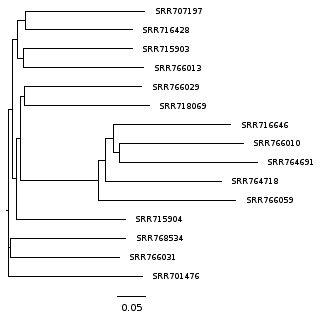

In [219]:
Image("11.Phylip/TreeOut.png")